In [716]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace, cauchy, multivariate_normal

np.random.seed(0)

from utils import traceplot, acfplot

# Generalised Normal Distribution

**Parameters:**

-   $\mu$: Location parameter.
-   $\alpha > 0$: Scale parameter.
-   $\beta > 0$: Shape parameter.

**PDF:**
$$f(x) \propto \exp \left\{- \left( \frac{|x - \mu|}{\alpha} \right)^\beta \right\}$$

**Log PDF:**
$$\log f(x) \propto - \left(\frac{|x - \mu|}{\alpha}\right)^\beta$$

**First derivative of log PDF:**
$$\frac{\text{d}}{\text{d} x} \log f(x) = -\frac{\beta}{\alpha} \left(\frac{|x - \mu|}{\alpha}\right)^{\beta - 1} \text{sgn}(x - \mu)$$

**Second derivative of log PDF:**
$$\frac{\text{d}^2}{\text{d} x^2} \log f(x) = -\frac{\beta (\beta - 1)}{\alpha^2} \left(\frac{|x - \mu|}{\alpha}\right)^{\beta - 2}$$

**Third derivative of log PDF:**
$$\frac{\text{d}^3}{\text{d} x^3} \log f(x) = - \frac{\beta (\beta - 1) (\beta - 2)}{\alpha^3} \left( \frac{|x - \mu|}{\alpha} \right)^{\beta - 3} \, \text{sgn}(x - \mu)$$


In [717]:
def logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (np.abs(x - mu) / alpha)**beta


def grad_logpi_gnd(x, mu=0, alpha=1, beta=2):
    epsilon = 1e-10
    diff = np.maximum(np.abs(x - mu) / alpha, epsilon)

    return - (beta / alpha) * diff**(beta - 1) * np.sign(x - mu)


def second_logpi_gnd(x, mu=0, alpha=1, beta=2):
    epsilon = 1e-10
    diff = np.maximum(np.abs(x - mu) / alpha, epsilon)

    return - (beta * (beta - 1) / alpha**2) * diff**(beta - 2)  # Negative for beta > 0 and x != mu


def third_logpi_gnd(x, mu=0, alpha=1, beta=2):
    epsilon = 1e-10
    diff = np.maximum(np.abs(x - mu) / alpha, epsilon)

    return - (beta * (beta - 1) * (beta - 2) / alpha**3) * diff**(beta - 3) * np.sign(x - mu)

# MALA

$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} \nabla \log \pi(x),
    \ h
\right)
$$


In [718]:
def mala_proposal(x, grad_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * grad_logpi_x + z


def mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size):
    log_xy = norm.logpdf(y, loc=(x + (1/2) * (step_size**2) * grad_logpi_x), scale=step_size)
    log_yx = norm.logpdf(x, loc=(y + (1/2) * (step_size**2) * grad_logpi_y), scale=step_size)
    
    return log_yx - log_xy


def mala(n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((x.shape[0], n_iter+1))
    x_samples[:, 0] = x

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi_gnd(x, **kwargs)

    for i in range(1, n_iter+1):
        grad_logpi_x = grad_logpi_gnd(x, **kwargs)
        
        # Generate a proposal state
        y = mala_proposal(x, grad_logpi_x, step_size)
        
        logpi_y = logpi_gnd(y, **kwargs)
        grad_logpi_y = grad_logpi_gnd(y, **kwargs)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

In [826]:
mala_samples1, accept_rate = mala(n_iter=1000, x_init=[1], beta=1, step_size=2.15)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.537


In [827]:
mala_samples2, accept_rate = mala(n_iter=1000, x_init=[1], beta=2, step_size=1.3)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.563


In [828]:
mala_samples3, accept_rate = mala(n_iter=1000, x_init=[1], beta=3, step_size=0.374)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.973


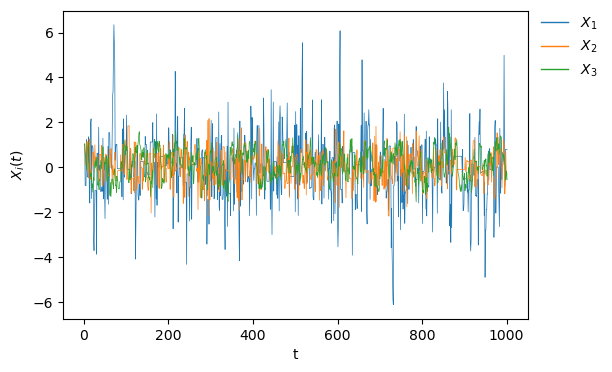

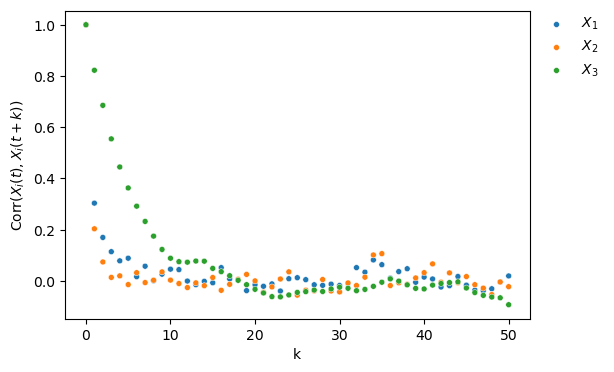

In [829]:
mala_samples = np.vstack([mala_samples1, mala_samples2, mala_samples3])
traceplot(mala_samples)
acfplot(mala_samples)

# MMALA


$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} A(x) \nabla \log \pi(x) + h \Gamma(x),
    \ h A(x)
\right)
$$

$$A(x) = \mathbb{E} \left( - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \right) = - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \quad (?)$$

$$\Gamma(x) = \frac{1}{2} \frac{\text{d}^3}{\text{d} x^3} \log f(x)$$


In [830]:
def mmala_proposal(x, grad_logpi_x, A_x, Gamma_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) * np.sqrt(A_x)

    return x + (1/2) * (step_size**2) * A_x * grad_logpi_x + (step_size**2) * Gamma_x + z


def mmala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, A_x, A_y, Gamma_x, Gamma_y, step_size):
    loc_xy = x + (1/2) * (step_size**2) * A_x * grad_logpi_x + (step_size**2) * Gamma_x
    loc_yx = y + (1/2) * (step_size**2) * A_y * grad_logpi_y + (step_size**2) * Gamma_y

    scale_xy = step_size * np.sqrt(A_x)
    scale_yx = step_size * np.sqrt(A_y)

    log_xy = norm.logpdf(y, loc=loc_xy, scale=scale_xy)
    log_yx = norm.logpdf(x, loc=loc_yx, scale=scale_yx)
    
    return log_yx - log_xy


def mmala(n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((x.shape[0], n_iter+1))
    x_samples[:, 0] = x

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi_gnd(x, **kwargs)

    for i in range(1, n_iter+1):
        grad_logpi_x = grad_logpi_gnd(x, **kwargs)
        A_x = np.abs(second_logpi_gnd(x, **kwargs))  # ????????
        Gamma_x = - (1/2) * third_logpi_gnd(x, **kwargs)
        
        # Generate a proposal state
        y = mmala_proposal(x, grad_logpi_x, A_x, Gamma_x, step_size)
        
        logpi_y = logpi_gnd(y, **kwargs)
        grad_logpi_y = grad_logpi_gnd(y, **kwargs)
        A_y = np.abs(second_logpi_gnd(y, **kwargs))
        Gamma_y = - (1/2) * third_logpi_gnd(y, **kwargs)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mmala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, A_x, A_y, Gamma_x, Gamma_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

In [831]:
mmla_samples1, accept_rate = mmala(n_iter=1000, x_init=[1], beta=1, step_size=1e-9)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.0


/opt/miniconda3/envs/fyp/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [852]:
mmala_samples2, accept_rate = mmala(n_iter=1000, x_init=[1], beta=2, step_size=0.93)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.581


In [856]:
mmala_samples3, accept_rate = mmala(n_iter=1000, x_init=[1], beta=3, step_size=0.25)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.579


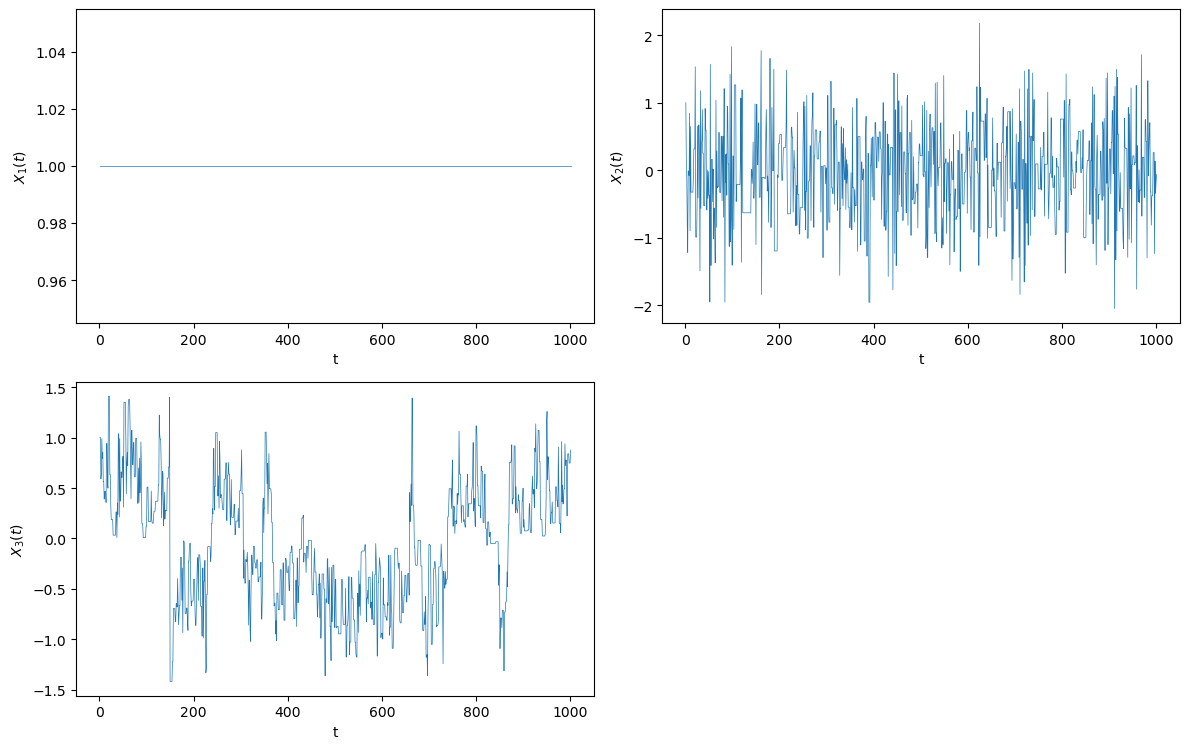

/opt/miniconda3/envs/fyp/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


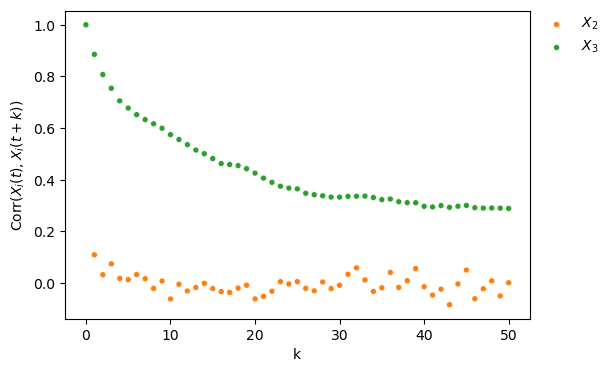

In [857]:
mmala_samples = np.vstack([mmla_samples1, mmala_samples2, mmala_samples3])
traceplot(mmala_samples, overlay=False)
acfplot(mmala_samples)

# SMMALA

$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} A(x) \nabla \log \pi(x),
    \ h A(x)
\right)
$$

$$A(x) = \mathbb{E} \left( - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \right) = - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \quad (?)$$


In [756]:
def smmala_proposal(x, grad_logpi_x, A_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) 

    return x + (1/2) * (step_size**2) * A_x * grad_logpi_x + z * np.sqrt(A_x)


def smmala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, A_x, A_y, step_size):
    loc_xy = x + (1/2) * (step_size**2) * A_x * grad_logpi_x
    loc_yx = y + (1/2) * (step_size**2) * A_y * grad_logpi_y

    scale_xy = step_size * np.sqrt(A_x)
    scale_yx = step_size * np.sqrt(A_y)

    log_xy = norm.logpdf(y, loc=loc_xy, scale=scale_xy)
    log_yx = norm.logpdf(x, loc=loc_yx, scale=scale_yx)
    
    return log_yx - log_xy


def smmala(n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((x.shape[0], n_iter+1))
    x_samples[:, 0] = x

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi_gnd(x, **kwargs)

    for i in range(1, n_iter+1):
        grad_logpi_x = grad_logpi_gnd(x, **kwargs)
        A_x = np.abs(second_logpi_gnd(x, **kwargs))  # ????????
        
        # Generate a proposal state
        y = smmala_proposal(x, grad_logpi_x, A_x, step_size)
        
        logpi_y = logpi_gnd(y, **kwargs)
        grad_logpi_y = grad_logpi_gnd(y, **kwargs)
        A_y = np.abs(second_logpi_gnd(y, **kwargs))

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + smmala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, A_x, A_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

In [818]:
smmala_samples1, accept_rate = smmala(n_iter=1000, x_init=[1], beta=1, step_size=1e-12)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.0


/opt/miniconda3/envs/fyp/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2068: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [819]:
smmala_samples2, accept_rate = smmala(n_iter=1000, x_init=[1], beta=2, step_size=0.93)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.532


In [820]:
smmala_samples3, accept_rate = smmala(n_iter=1000, x_init=[1], beta=3, step_size=0.55)

print(f'Acceptance rate:{accept_rate}')

Acceptance rate:0.577


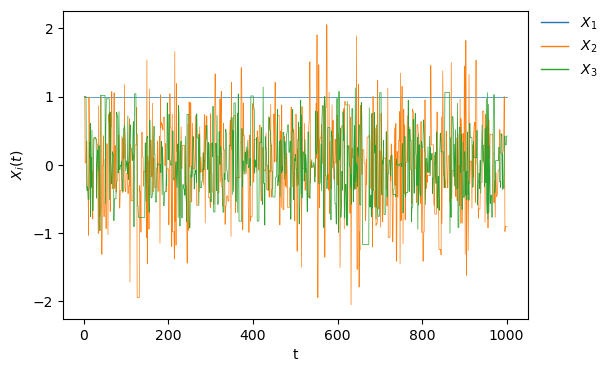

/opt/miniconda3/envs/fyp/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


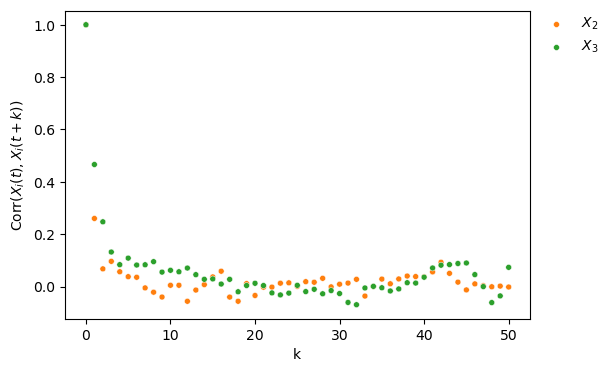

In [821]:
smmala_samples = np.vstack([smmala_samples1, smmala_samples2, smmala_samples3])
traceplot(smmala_samples)
acfplot(smmala_samples)